In [11]:
import pandas as pd
import importlib
#import fileDistanceProcessing as fdp
import importlib
#importlib.reload(fdp) 

In [12]:
X=pd.read_csv("../data/csv/sars2_mers_sars1.txt",skipinitialspace = True )

In [13]:
X.columns = X.columns.str.strip()
X.columns

Index(['Virus', 'ACCESSION', 'WHO_TYPE', 'ACCESSION_PROT', 'PROTEIN',
       'DUZINA_NUC', 'KOD_NUC'],
      dtype='object')

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
pip install py7zr

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 862.4 kB/s eta 0:00:00MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 KB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 KB 719.4 kB/s eta 0:00:0031m2.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 KB 1.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 1.1 MB/s eta 0:00:00m eta 0:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pickle
import os
import py7zr
from zipfile import ZipFile



#raspakuj arhivu
with py7zr.SevenZipFile("../data/full_distances_matrix.7z",'r') as zip:
    zip.extractall("..")

In [8]:
# upcitaj matricu distanci
with open("../data/full_distances_matrix", "rb") as infile:
     	distances = pickle.load(infile)

os.remove("../data/full_distances_matrix")

In [9]:
# metrika zasnovana samo na 5-adic distanci
# instant racunanje iz matrice
def five_adic_distance_from_matrix(x, y):
    
    i = int(x[-1]) #indeks je na poslednjem mestu u listi
    j = int(y[-1])

    # matrica je u obliku trougla bez dijagonale originalne matrice
    first = min(i, j)
    second = max(i, j) - (first + 1) # veci indeks smanji za broj instanci u redu matrice do dijagonale 

    return 0 if i == j else distances[first][second] #udaljenost x od y

In [40]:
y_virus=X["Virus"]
X_virus=[] # potreban nam je samo indeks
labels=y_virus.unique()
# na svaku instancu X_virus smo appendovali njen index
for i in range(len(y_virus)):
    X_virus.append([0, i]) # 0 je dodata zbog knn da ne pravi problem
    
X_train, X_test, y_train, y_test = train_test_split(X_virus, y_virus, test_size=0.33, stratify=y_virus)

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualisation_cm(cm,labels):

    plt.figure(figsize=(15,15), dpi=100)

    plt.tight_layout()
    zbir_po_redu = cm.sum(axis=1, keepdims=True)  
    normalizovana_matrica = cm / zbir_po_redu  

    print("Originalna matrica:")
    print(cm)
    print("\nNormalizovana matrica:")
    print(normalizovana_matrica)

    
    ax = sns.heatmap(normalizovana_matrica, annot=True, cmap="Greens",linewidth=.5,fmt=".2f", cbar_kws={"shrink": 0.8})

    ax.set_xlabel("Predvidjeno", fontsize=14)
    ax.xaxis.set_ticklabels(labels)


    ax.set_ylabel("Stvarno", fontsize=14)
    ax.yaxis.set_ticklabels(labels)
   
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    #ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

    plt.show()

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix

def perform_and_evaluate_knn(k, metric,X_train,X_test,y_train,y_test,labels):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric=metric)
    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)
    print(f'model evalutaion for k={k} and metric={str(metric)}')
    print(f'accuracy_score: {accuracy_score(y_test,y_pred)}')
    cm= confusion_matrix(y_test,y_pred,labels=labels)
    visualisation_cm(cm,labels)

model evalutaion for k=3 and metric=<function five_adic_distance_from_matrix at 0x7426a17785e0>
accuracy_score: 0.9986229056690383
Originalna matrica:
[[3740    0    0]
 [   2  609    0]
 [   3    1    2]]

Normalizovana matrica:
[[1.         0.         0.        ]
 [0.00327332 0.99672668 0.        ]
 [0.5        0.16666667 0.33333333]]


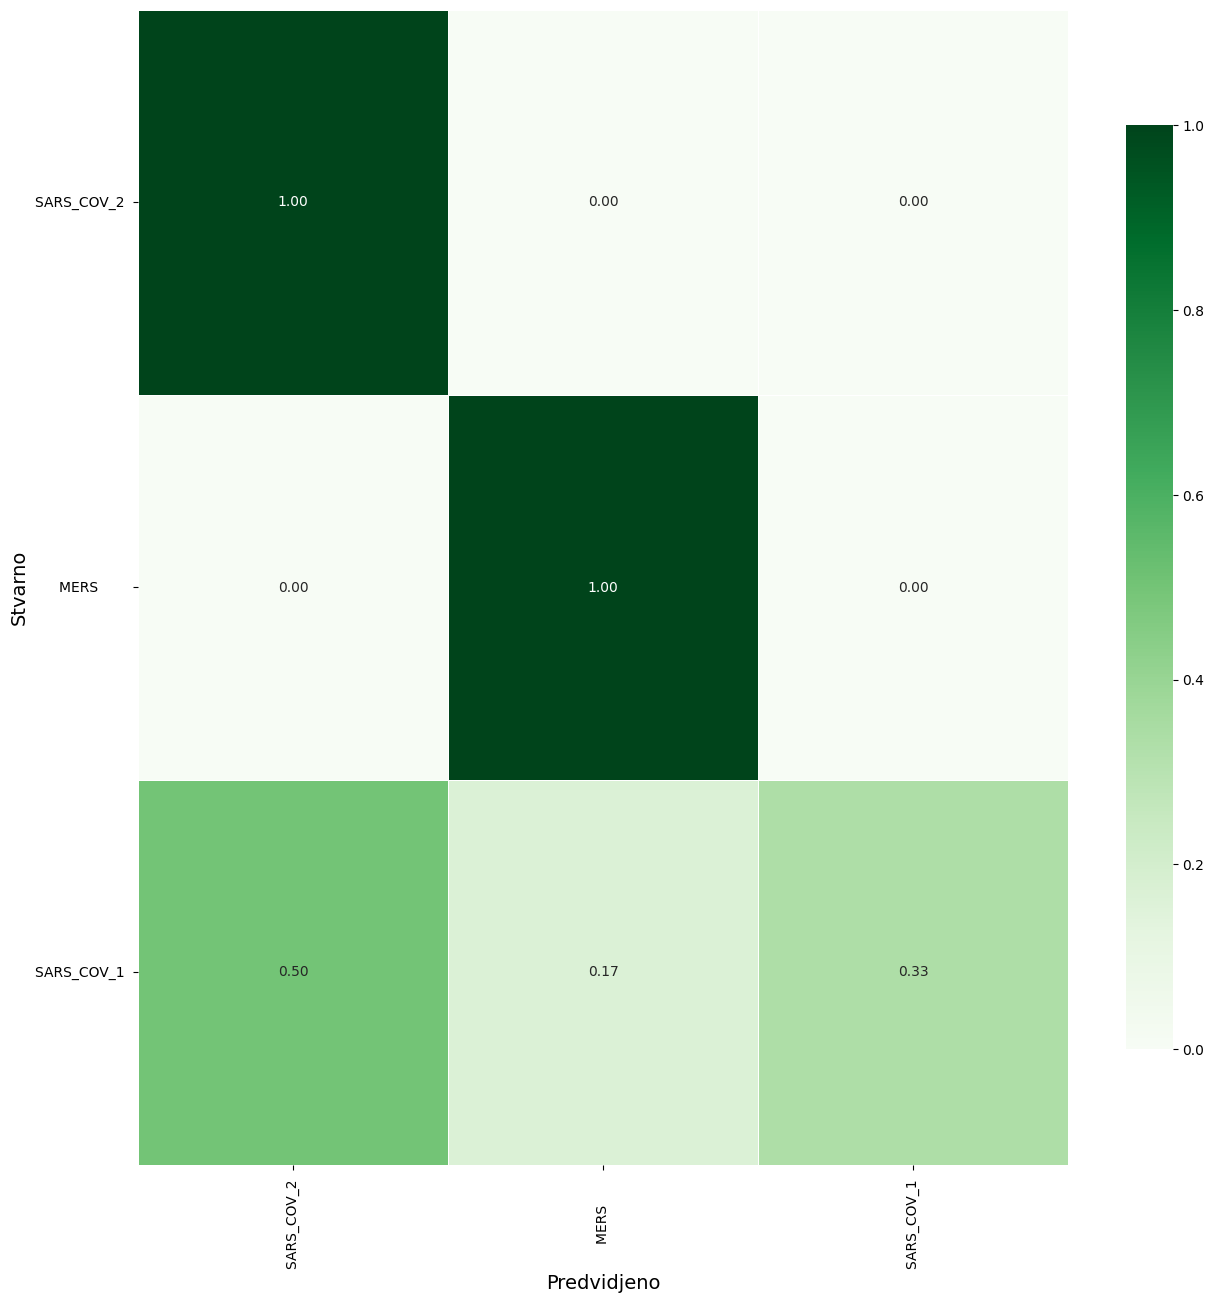

In [41]:
perform_and_evaluate_knn(3, five_adic_distance_from_matrix,X_train,X_test,y_train,y_test,labels)

In [44]:
y_protein = X["PROTEIN"]
X_protein = X_virus
labels=y_protein.unique()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_protein, y_protein, test_size=0.33, stratify=y_protein)

model evalutaion for k=3 and metric=<function five_adic_distance_from_matrix at 0x7426a17785e0>
accuracy_score: 0.9986229056690383
Originalna matrica:
[[1897    2    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0 1371    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0  550    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    8    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0   24    0    0    0    0    1    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0   73    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0  211    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    3    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0   45    0    0    0    0    0
     0    0    0 

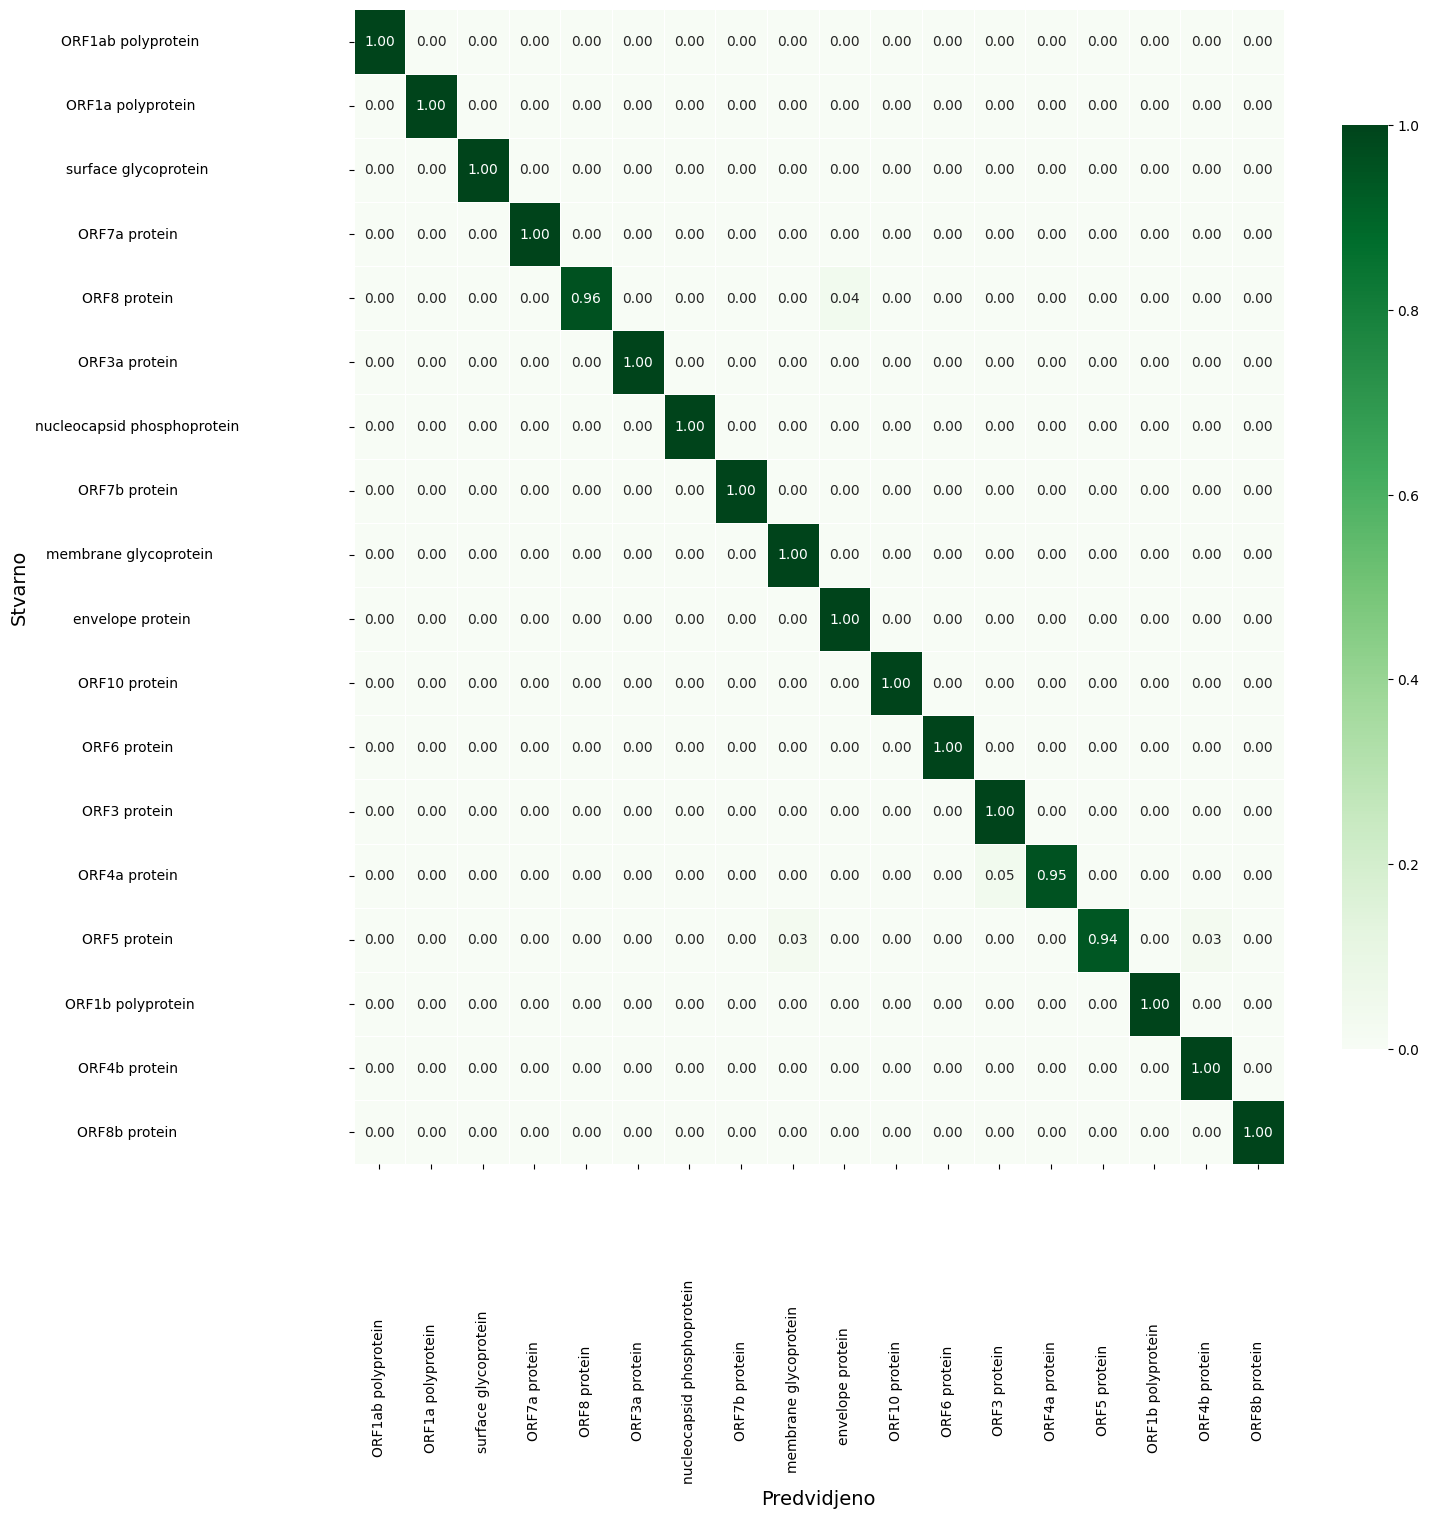

In [46]:
perform_and_evaluate_knn(3, five_adic_distance_from_matrix,X_train,X_test,y_train,y_test,labels)

In [28]:
import numpy as np

virusTypes = np.array(X['Virus'])
X_who = []
indexes = []
for i in range(len(virusTypes)):
    if(virusTypes[i].strip() == "SARS_COV_2"):
        X_who.append([0, i])
        indexes.append(i)

sars2_only = X.filter(items=indexes, axis=0)

In [29]:
y_who=sars2_only["WHO_TYPE"].str.strip()
labels=y_who.unique()
X_train, X_test, y_train, y_test = train_test_split(X_who, y_who, test_size=0.33, stratify=y_who)

model evalutaion for k=3 and metric=<function five_adic_distance_from_matrix at 0x7426a17785e0>
accuracy_score: 0.9652406417112299
Originalna matrica:
[[487   0   2   1   0   0   0   0   4   1   0   0   0]
 [  2 474   1   1   0   7   0   3   4   2   1   0   0]
 [  1   1 487   1   0   1   0   1   1   1   0   1   0]
 [  1   0   2 485   0   2   0   0   2   0   0   2   1]
 [  3   1   3   2 481   2   0   0   0   2   1   0   0]
 [  4   3   3   1   4 478   0   0   1   0   1   0   0]
 [  3   3   0   0   0   0 146   0   2   0   0   0   0]
 [  1   3   4   0   0   0   0  43   1   0   0   0   0]
 [  1   0   1   0   3   1   0   0 187   0   0   0   0]
 [  6   1   1   1   1   2   0   0   4 191   0   0   0]
 [  3   2   1   0   1   0   0   0   1   0 127   0   0]
 [  1   0   1   0   0   0   0   0   2   0   0  18   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   6]]

Normalizovana matrica:
[[0.98383838 0.         0.0040404  0.0020202  0.         0.
  0.         0.         0.00808081 0.0020202  0. 

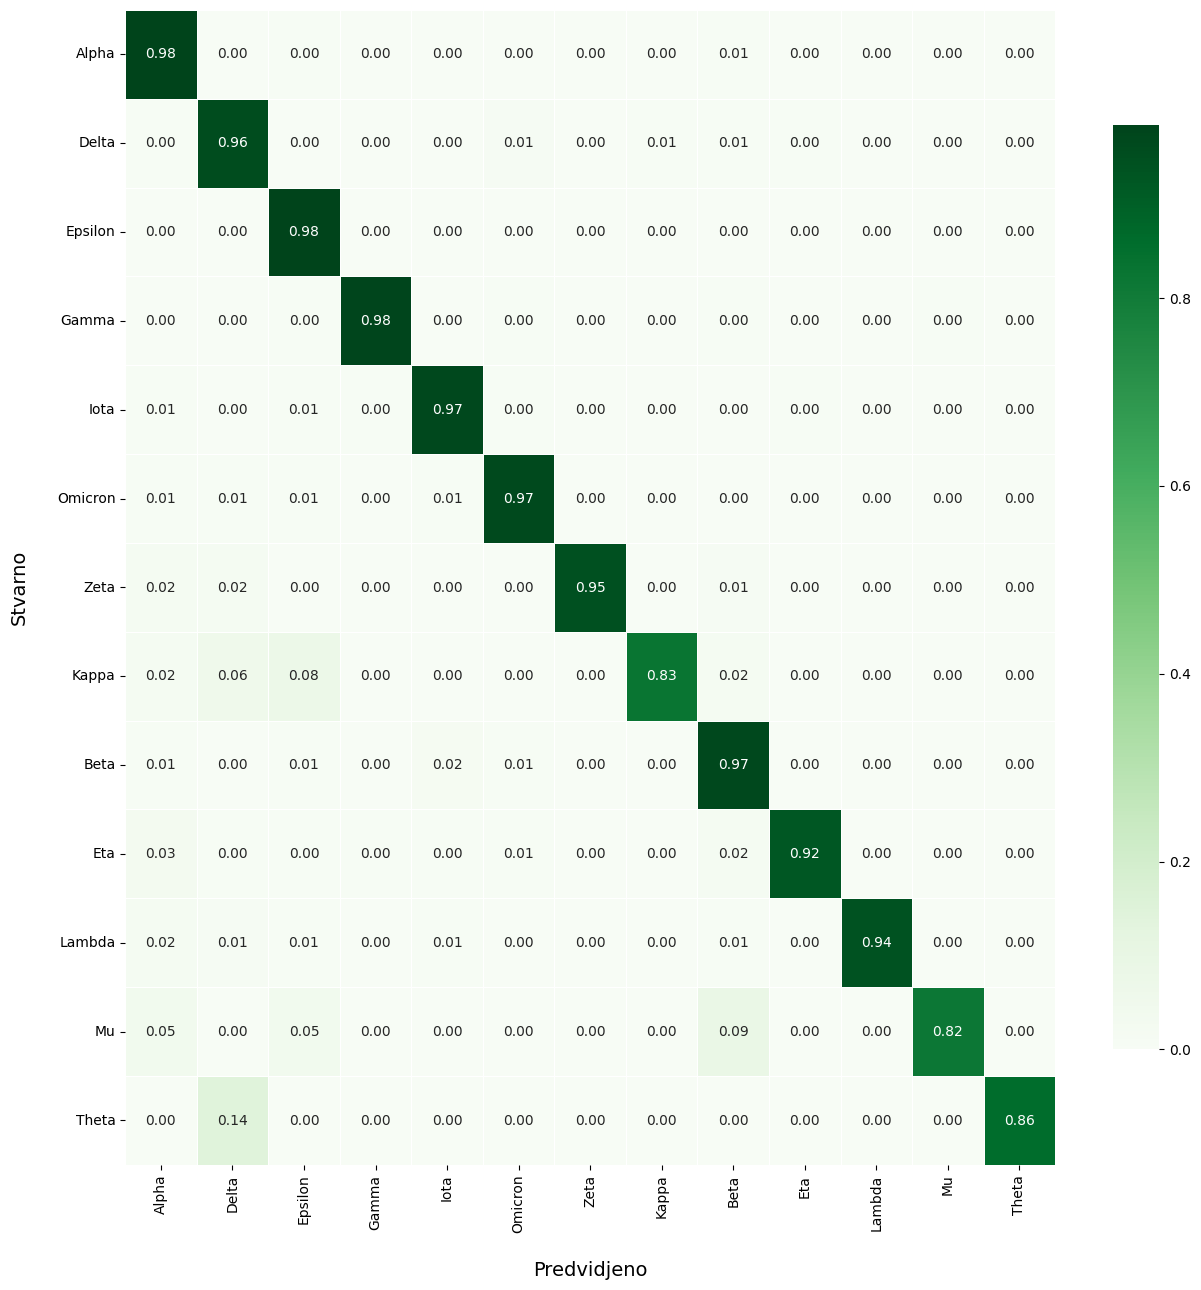

In [30]:
perform_and_evaluate_knn(3, five_adic_distance_from_matrix,X_train,X_test,y_train,y_test,labels)

In [48]:
X_train


[[0, 5323],
 [0, 5651],
 [0, 5754],
 [0, 4753],
 [0, 11376],
 [0, 4179],
 [0, 2795],
 [0, 7071],
 [0, 4920],
 [0, 5708],
 [0, 9550],
 [0, 11733],
 [0, 5090],
 [0, 12873],
 [0, 12066],
 [0, 4811],
 [0, 2222],
 [0, 12923],
 [0, 7319],
 [0, 7670],
 [0, 11040],
 [0, 3353],
 [0, 1250],
 [0, 1034],
 [0, 2929],
 [0, 4665],
 [0, 6246],
 [0, 4069],
 [0, 6140],
 [0, 8062],
 [0, 7486],
 [0, 10606],
 [0, 11116],
 [0, 11153],
 [0, 2007],
 [0, 5067],
 [0, 5613],
 [0, 4824],
 [0, 6806],
 [0, 11629],
 [0, 9712],
 [0, 9978],
 [0, 5653],
 [0, 858],
 [0, 6494],
 [0, 11544],
 [0, 12895],
 [0, 10155],
 [0, 8485],
 [0, 245],
 [0, 46],
 [0, 7406],
 [0, 8771],
 [0, 7587],
 [0, 4821],
 [0, 7152],
 [0, 12282],
 [0, 3153],
 [0, 1008],
 [0, 5436],
 [0, 4779],
 [0, 7677],
 [0, 7370],
 [0, 10672],
 [0, 12408],
 [0, 117],
 [0, 6266],
 [0, 7014],
 [0, 3340],
 [0, 4942],
 [0, 6296],
 [0, 10288],
 [0, 9400],
 [0, 11262],
 [0, 13188],
 [0, 11367],
 [0, 10114],
 [0, 3863],
 [0, 8040],
 [0, 3426],
 [0, 4511],
 [0, 2857],
